In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt

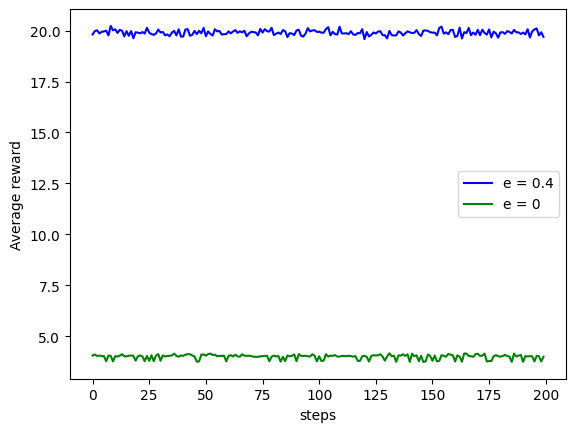

In [ ]:
def epsilon_greedy_bandit(bandit, k, epsilon=0.4, steps=100):
    """
    bandit: function that takes an action index (0..k-1) and returns a reward
    k: number of arms
    epsilon: exploration probability
    steps: number of steps to run
    """
    Q = [0.0] * k  # estimated values
    N = [0] * k  # action counts

    for _ in range(steps):
        # Choose action
        if random.random() < epsilon:
            A = random.randrange(k)  # explore
        else:
            max_Q = max(Q)
            # break ties randomly among best actions
            best_actions = [i for i, q in enumerate(Q) if q == max_Q]
            A = random.choice(best_actions)

        # Take action and observe reward
        R = bandit(A)

        # Incremental update of Q(A)
        N[A] += 1
        Q[A] += (R - Q[A]) / N[A]

    return Q, N


# Define a simple bandit with 5 arms
true_means = np.random.normal(20, 1, 5)


def bandit(a):
    # stochastic reward based on normal distribution around true mean
    return np.random.normal(true_means[a], 1)


k = len(true_means)
runs = 200
steps = 100

Qeg = np.zeros((runs, k))
Neg = np.zeros((runs, k))

Qg = np.zeros((runs, k))
Ng = np.zeros((runs, k))

for i in range(runs):
    Qeg[i], Neg[i] = epsilon_greedy_bandit(bandit, k=k, epsilon=0.4, steps=steps)
    Qg[i], Ng[i] = epsilon_greedy_bandit(bandit, k=k, epsilon=0, steps=steps)

Qegavg = np.mean(Qeg, axis=1)
Negavg = np.mean(Neg, axis=1)

Qgavg = np.mean(Qg, axis=1)
Ngavg = np.mean(Ng, axis=1)

# Plot average Q
plt.plot(Qegavg, label="e = 0.4", color="blue")
plt.plot(Qgavg, label="e = 0", color="green")
# plt.ylim(, 1.5)
plt.xlabel("steps")
plt.ylabel("Average reward")
plt.legend()
plt.show()